In [16]:
import cv2 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms

from collections import Counter

from tqdm import trange

import numpy as np

from matplotlib import pyplot as plt

In [2]:
data_path = 'Fashion/data'
train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.Compose([
                            transforms.Grayscale(num_output_channels=1), 
                            transforms.ToTensor()]))

test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.Compose([
                            transforms.Grayscale(num_output_channels=1), 
                            transforms.ToTensor()]))

classes = ['T-shitr/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
print(f'Original labels: {classes}\n')
print(f'Trainset:\t[{len(train)}, {len(train[0])}, {len(train[0][0])}, {len(train[0][0][0])}, {len(train[0][0][0][0])}]')
print(f'Testset:\t[{len(test)}, {len(test[0])}, {len(test[0][0])}, {len(test[0][0][0])}, {len(test[0][0][0][0])}]')

Original labels: ['T-shitr/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Trainset:	[60000, 2, 1, 28, 28]
Testset:	[10000, 2, 1, 28, 28]


In [3]:
dc = [3,4,5,6,9]

t_label=[]
t_img=[]

for img, label in train:
    if label != dc[0] and label != dc[1] and label != dc[2] and label != dc[3] and label != dc[4]:
        t_img.append(img)
        t_label.append(label)
    

v_label=[]
v_img=[]

for img, label in test:
    if label != dc[0] and label != dc[1] and label != dc[2] and label != dc[3] and label != dc[4]:
        v_img.append(img)
        v_label.append(label)

        
erased=[]
for i in range(len(dc)):
    erased.append(classes.pop(dc[i]-i))
    
print(f'Erased labels: {erased}')

t_label = [3 if x == 8 else x for x in t_label]
t_label = [4 if x == 7 else x for x in t_label]

v_label = [3 if x == 8 else x for x in v_label]
v_label = [4 if x == 7 else x for x in v_label]

Erased labels: ['Dress', 'Coat', 'Sandal', 'Shirt', 'Ankle boot']


In [4]:
print(f'Number of labels: {len(classes)}')
print(f'Final labels: {classes}')

f_index=list(Counter(t_label).keys())
f_index.sort()

print(f'Final index: {f_index}\n')


X_s = torch.Tensor(len(t_img), len(t_img[0]), len(t_img[0][0]), len(t_img[0][0][0]))
X_a_s = torch.Tensor(len(v_img), len(v_img[0]), len(v_img[0][0]), len(v_img[0][0][0]))

print(f'Trainset:\t{X_s.shape}\tLabels:\t{len(t_label)}')
print(f'Testset:\t{X_a_s.shape}\tLabels:\t{len(v_label)}\n\n')

X = torch.cat(t_img, dim=0, out=X_s)
Y = torch.tensor(t_label)

X_a = torch.cat(v_img, dim=0, out=X_a_s)
Y_a = torch.tensor(v_label)

print(f'Trainset:\t{X.shape}')
print(f'Testset:\t{X_a.shape}')

Number of labels: 5
Final labels: ['T-shitr/top', 'Trouser', 'Pullover', 'Sneaker', 'Bag']
Final index: [0, 1, 2, 3, 4]

Trainset:	torch.Size([30000, 1, 28, 28])	Labels:	30000
Testset:	torch.Size([5000, 1, 28, 28])	Labels:	5000


Trainset:	torch.Size([30000, 28, 28])
Testset:	torch.Size([5000, 28, 28])


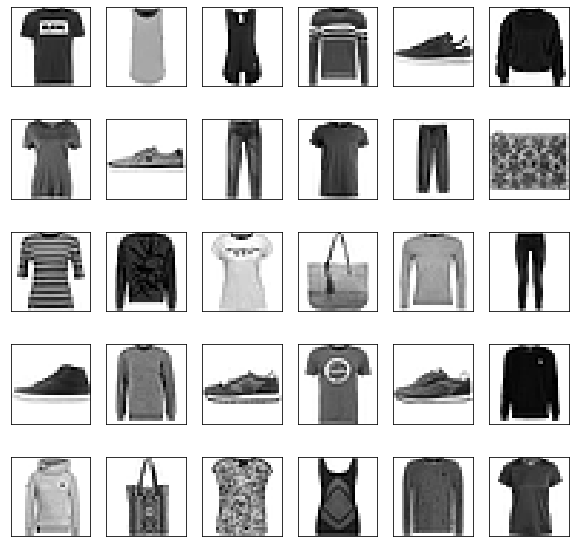

In [22]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(X[i],cmap=plt.cm.binary)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        
        self.fc1=nn.Linear(32*4*4, 170, bias=True)
        self.fc2=nn.Linear(170, 56, bias=True)
        self.fc3=nn.Linear(56, 5, bias=True)
    
    def forward(self,x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        x = torch.flatten(x, start_dim=1)
        
        x= F.relu(self.fc1(x)) 
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        
        return F.softmax(x, dim=1)

In [6]:
torch.cuda.empty_cache()
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    net_class = Net().to(device)
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    net_class = Net()
    print("Running on the CPU")

Running on the GPU


In [7]:
batch_size = 10
epochs = 35

optimizer = optim.Adam(net_class.parameters(),lr= 0.0008)
loss_function = nn.CrossEntropyLoss()

loss_grap=[]
mean_grap=[]
prin = True

for epoch in range(epochs):
    loss_mean=0
    for i in trange(0, len(X), batch_size,  desc='Loss calculation'):
        
        batch_X=X[i:i+batch_size].view(-1,1,28,28)
        batch_y=Y[i:i+batch_size]
        
        x,y = batch_X.to(device), batch_y.to(device)
        
        net_class.zero_grad()
        
        output=net_class(x.view(-1,1,28,28))
        
        if prin:
            print(f'Output shape: {output.shape}\t Y shape: {y.shape}')
            prin = False
        
        loss = loss_function(output, y)
        
        loss.backward()
        
        optimizer.step()
        
        loss_grap.append(loss)
    
        loss_mean+=loss
        
    print(f'Epoch {epoch+1} error mean {((loss_mean/i).item()):.5f}')
    mean_grap.append((loss_mean/i).item())

Loss calculation:   0%|          | 11/3000 [00:01<39:19,  1.27it/s]

Output shape: torch.Size([10, 5])	 Y shape: torch.Size([10])


Loss calculation:   0%|          | 10/3000 [00:00<00:32, 91.96it/s]

Epoch 1 error mean 0.09732


Loss calculation:   0%|          | 10/3000 [00:00<00:32, 91.62it/s]

Epoch 2 error mean 0.09410


Loss calculation:   0%|          | 8/3000 [00:00<00:42, 69.74it/s]

Epoch 3 error mean 0.09346


Loss calculation:   0%|          | 8/3000 [00:00<00:40, 73.59it/s]

Epoch 4 error mean 0.09327


Loss calculation:   0%|          | 8/3000 [00:00<00:38, 78.25it/s]

Epoch 5 error mean 0.09315


Loss calculation:   0%|          | 8/3000 [00:00<00:45, 65.21it/s]

Epoch 6 error mean 0.09298


Loss calculation:   0%|          | 9/3000 [00:00<00:36, 82.04it/s]

Epoch 7 error mean 0.09293


Loss calculation:   0%|          | 10/3000 [00:00<00:32, 91.15it/s]

Epoch 8 error mean 0.09299


Loss calculation:   0%|          | 8/3000 [00:00<00:41, 72.26it/s]

Epoch 9 error mean 0.09318


Loss calculation:   0%|          | 8/3000 [00:00<00:40, 74.61it/s]

Epoch 10 error mean 0.09294


Loss calculation:   0%|          | 8/3000 [00:00<00:39, 74.97it/s]

Epoch 11 error mean 0.09289


Loss calculation:   0%|          | 8/3000 [00:00<00:41, 72.92it/s]

Epoch 12 error mean 0.09285


Loss calculation:   0%|          | 8/3000 [00:00<00:42, 69.75it/s]

Epoch 13 error mean 0.09288


Loss calculation:   0%|          | 10/3000 [00:00<00:32, 92.84it/s]

Epoch 14 error mean 0.09281


Loss calculation:   1%|          | 18/3000 [00:00<00:33, 89.35it/s]

Epoch 15 error mean 0.09286


Loss calculation:   0%|          | 7/3000 [00:00<00:47, 62.67it/s]

Epoch 16 error mean 0.09289


Loss calculation:   0%|          | 6/3000 [00:00<00:52, 57.30it/s]

Epoch 17 error mean 0.09288


Loss calculation:   0%|          | 10/3000 [00:00<00:32, 91.15it/s]

Epoch 18 error mean 0.09313


Loss calculation:   0%|          | 6/3000 [00:00<00:56, 52.77it/s]

Epoch 19 error mean 0.09284


Loss calculation:   0%|          | 5/3000 [00:00<01:09, 42.85it/s]

Epoch 20 error mean 0.09307


Loss calculation:   0%|          | 9/3000 [00:00<00:36, 81.30it/s]

Epoch 21 error mean 0.09316


Loss calculation:   0%|          | 10/3000 [00:00<00:33, 90.35it/s]

Epoch 22 error mean 0.09310


Loss calculation:   0%|          | 7/3000 [00:00<00:43, 68.11it/s]

Epoch 23 error mean 0.09332


Loss calculation:   0%|          | 6/3000 [00:00<00:52, 57.02it/s]

Epoch 24 error mean 0.09313


Loss calculation:   0%|          | 8/3000 [00:00<00:42, 70.99it/s]

Epoch 25 error mean 0.09309


Loss calculation:   0%|          | 7/3000 [00:00<00:48, 61.57it/s]

Epoch 26 error mean 0.09278


Loss calculation:   0%|          | 7/3000 [00:00<00:44, 66.85it/s]

Epoch 27 error mean 0.09312


Loss calculation:   0%|          | 10/3000 [00:00<00:31, 93.71it/s]

Epoch 28 error mean 0.09292


Loss calculation:   0%|          | 10/3000 [00:00<00:32, 91.15it/s]

Epoch 29 error mean 0.09303


Loss calculation:   0%|          | 9/3000 [00:00<00:36, 82.79it/s]

Epoch 30 error mean 0.09288


Loss calculation:   0%|          | 9/3000 [00:00<00:34, 87.61it/s]

Epoch 31 error mean 0.09341


Loss calculation:   0%|          | 9/3000 [00:00<00:33, 88.47it/s]

Epoch 32 error mean 0.09301


Loss calculation:   0%|          | 7/3000 [00:00<00:43, 68.81it/s]

Epoch 33 error mean 0.09278


Loss calculation:   0%|          | 6/3000 [00:00<00:55, 54.20it/s]

Epoch 34 error mean 0.09272


Loss calculation: 100%|██████████| 3000/3000 [00:48<00:00, 61.46it/s]

Epoch 35 error mean 0.09292


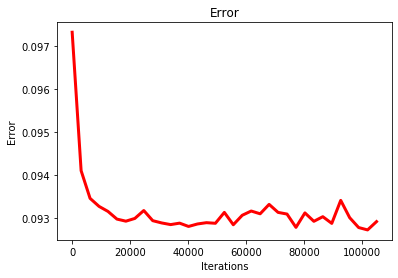

In [12]:
xpt=np.linspace(0,len(loss_grap),len(mean_grap))
xpt=[int(i) for i in xpt]

plt.plot(xpt,mean_grap,c='red',lw=3)

plt.title('Error')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()

In [14]:
correct = 0
total = 0
with torch.no_grad():
    
    for i in trange(len(X_a), desc='Accuracy calculation'):
        
        X_a,Y_a = X_a.to(device), Y_a.to(device)
        
        net_out = net_class(X_a[i].view(-1,1,28,28))[0]
        
        predicted_class = torch.argmax(net_out)
        
        if predicted_class == Y_a[i]:
            correct += 1
        total += 1

print("Accuracy: ",round(correct/total,3))

Accuracy calculation: 100%|██████████| 5000/5000 [00:15<00:00, 321.25it/s]

Accuracy:  0.977


In [15]:
classes

['T-shitr/top', 'Trouser', 'Pullover', 'Sneaker', 'Bag']